---

# CSCI 3352, Spring 2022
# FINAL PROJECT

<br> 

### Owen Smith, Kyle Ma

<br> 

In [1]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import math
import matplotlib
import matplotlib.pylab as plt
from sklearn import tree
from pyvis.network import Network
import csv

In [2]:
### ITERATE THROUGH NETWORKS DIRECTORY, HANDLE FILES ###
directory = 'networks'
for filename in os.scandir(directory):
    filename = filename.name
    name, ext = os.path.splitext(filename)
    ext = str(ext)[0:4]
    if ext == '.csv' and filename != 'references.csv':
        data = np.loadtxt(open(directory + '/' + filename, "rb"), delimiter=",", skiprows=1)
        edgelist = ''
        listfile = open(directory + '/' + filename[:-4] + '.txt', 'w')
        for row in range(0, len(data)):
            for col in range(0, len(data[row])):
                if data[row][col] != 0:
                    edgelist = edgelist + str(row) + ' ' + str(col) + '\n'
        d = listfile.write(edgelist)
        listfile.close()

In [3]:
# takes in a graph G and returns a list of network statistics
def gather_network_stats(G):
    def compute_MGD(G):
        path = list((dict(nx.all_pairs_shortest_path_length(G)).values())) #takes return and converts to list of dicts
        Z = 0
        l_sum = 0

        for node in path:
            tmp = list(node.values()) #convert node dict to list of values
            tmp.remove(0) #remove all instances of 0
            Z = Z + len(tmp) #calculate Z from size of list
            l_sum = l_sum + sum(tmp) #add all the path lengths to the total for the numerator later on

        MGD = l_sum / Z
        return MGD
    
    def percent_single_degree(G): #gets percentage of nodes with degree of one, as these edge suggest specialized predation
        degrees = dict(G.degree())
        degrees = list(degrees.values())
        single_degree_count = 0
        for k in degrees:
            if k == 1:
                single_degree_count += 1
        return single_degree_count / G.number_of_nodes()

    def count_FFBL_motifs(G,flag):
        FFL_count = 0
        FBL_count = 0

        ### MY CODE ###
        FFL_pairs = [] #lists that will contain pairs for later printing if flag == 1
        FBL_pairs = []

        for i in G.nodes(): #loop for suggested enumeration
            for j in G.neighbors(i): #paths of length 1
                for k in G.neighbors(j): #paths of length 2
                    if (i != k): #eliminate bidirectionals
                        if (G.has_edge(i, k)): #if there is an edge from i -> k, it is a FFL
                            FFL_count += 1
                            FFL_pairs.append(((i,j), (j,k), (i,k)))
                        if (G.has_edge(k, i)): #if there is an edge from k -> i, it is a FBL
                            FBL_count += 1
                            FBL_pairs.append(((i,j), (j,k), (k,i)))

        FBL_count = int(FBL_count / 3) #divide FBL_count by 3 to retroactively account for duplicates

        if (flag == 1): #print flag
            for i in FFL_pairs:
                print("FFL: ", i)
            FBL_pairs = FBL_pairs[::3] #takes every third element to get rid of duplicates (kinda jank but it works)
            for i in FBL_pairs:
                print("FBL:", i)

        return (FFL_count,FBL_count)
    
    n = G.number_of_nodes() #builtin function that returns number of nodes as an int
    m = G.number_of_edges() #builtin funciton that reutnrs number of edges as an int
    
    degrees = dict(G.degree())
    totalDegrees = sum(degrees.values()) #get values, sum, divide by number of nodes
    kmean =  totalDegrees / n #calculate mean
    
    degree_lst = list(degrees.values())
    kmax = max(degree_lst)
    
    C = nx.transitivity(G)
    node_connectivity = nx.node_connectivity(G)
    MGD = compute_MGD(G)
    triangles = (sum(nx.triangles(G).values()) / 3) / n
    FFL_count, FBL_count = count_FFBL_motifs(G, 0)
    FFL_count = FFL_count / n
    FBL_count = FBL_count / n
    specialized_nodes = percent_single_degree(G)
    
    percent_cannibal = 0
    for node in G.nodes():
        if node in G.neighbors(node):
            percent_cannibal += 1
    percent_cannibal = percent_cannibal / n
    r = nx.radius(G)
    eccentricity = nx.eccentricity(G)
    return [n, m, kmean, kmax, C, node_connectivity, MGD, triangles, FFL_count, FBL_count, specialized_nodes, percent_cannibal, r, eccentricity]

In [4]:
def get_temp(filename):
    # returns temperature as a float
    df = pd.read_csv("our_references.csv")
    temp = df[["Filename", "Temperature"]]
    temperature = temp.loc[temp["Filename"] == filename,"Temperature"].iloc[0]
    return float(temperature)

In [5]:
def get_correlation_coefficients(data_array):
    # returns correlation coefficients as a list
    df = pd.DataFrame(data_array, columns = ['network', "nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD', 'triangles', 
                                             'FFL', 'FBL', 'special nodes', 'percent_cannibal', 'radius', 'eccentricity', 'Temperature'])
    correlations = df.corr()['Temperature'][:-1]
    print(df)
    return correlations #this line for returning as dataframe
    #return correlations.to_numpy()

Astyanax altiparanae
Detritus
Hypostomus strigaticeps
Astyanax fasciatus
Brycon nattereri
Detritus Animal
Import
Leporinus friderici
Hoplias malabaricus
Macrophytes
Phytoplankton


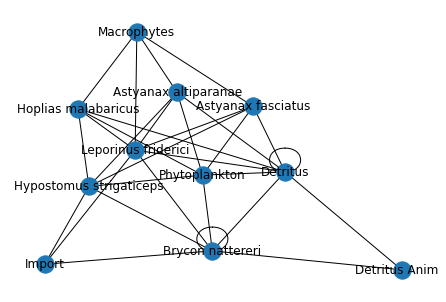

In [6]:
# iterates through networks directory and reads each in as networkx graph G
directory = 'networks'
data = []
show = True
for filename in os.scandir(directory):
    filename = filename.name
    name, ext = os.path.splitext(filename)
    ext = str(ext)[0:4]
    if ext == '.txt' and filename != 'README':
        G = nx.read_edgelist(directory + '/' + filename)
        network_stats = [filename]
        network_stats = network_stats + gather_network_stats(G)
        network_stats.append(get_temp(filename[:-4]))
        data.append(network_stats)
        if filename == "FW_002.txt":
            species = pd.read_csv("species/"+ filename[:-4] + ".csv")['Unnamed: 0']
            mapping = {}
            for i, a in enumerate(G.nodes()):
                mapping[a] = species[int(a)]
#                 print(len(G.nodes()))
#                 print(len(species))
                a = species[int(a)]
                print(a)
            H = nx.relabel_nodes(G, mapping)
            nx.draw(H, with_labels = True)
            net = Network(notebook = True)
            net = Network('2000px', '2000px')
            net.from_nx(H)
            net.show("test.html")
            show = False
    # nx.draw(G)
    # plt.show()

In [7]:
get_correlation_coefficients(data)

          network  nodes  degrees  average degrees  highest degree  \
0      FW_001.txt     39      171         8.769231              23   
1      FW_002.txt     11       30         5.454545               9   
2      FW_003.txt     26      110         8.461538              17   
3      FW_004.txt     32      131         8.187500              19   
4      FW_005.txt     43      353        16.418605              40   
5      FW_006.txt     30      207        13.800000              28   
6      FW_007.txt     42      208         9.904762              19   
7      FW_008.txt    247     3261        26.404858             197   
8      FW_009.txt     37      222        12.000000              32   
9      FW_010.txt     35      220        12.571429              30   
10     FW_011.txt     71      331         9.323944              50   
11  FW_012_01.txt     37      115         6.216216              26   
12  FW_012_02.txt     44      144         6.545455              32   
13  FW_013_01.txt   

nodes               0.357052
degrees             0.222279
average degrees    -0.146099
highest degree      0.421098
Cluster Coeff      -0.423891
connectivity        0.296302
MGD                -0.260248
triangles          -0.269406
FFL                -0.269870
FBL                -0.269883
special nodes      -0.169698
percent_cannibal   -0.171546
radius             -0.519179
Name: Temperature, dtype: float64

In [8]:
df = pd.DataFrame(data, columns = ['network', "nodes", "degrees", 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD', 'triangles', 
                                   'FFL', 'FBL', 'special nodes', 'percent_cannibal', 'radius', 'eccentricity', 'Temperature'])
X = df[['nodes', 'degrees', 'average degrees', 'highest degree', 'Cluster Coeff', 'connectivity', 'MGD', 'FFL', 'FBL', 'special nodes']]
y = df['Temperature']

num_trials = 10000
rand_set = list(range(0, 33))
rand_set_track = list(range(0, 33))
average_errors = []
X = X.to_numpy()
y = y.to_numpy()
empirical_net = {}
for trial in range(0, num_trials):
    # create lists and generate random indeces for training from global dataset
    errors = []
    empirical_set = []
    training_set = []
    empirical_set_temps = []
    training_set_temps = []
    training_set_indeces = np.random.choice(rand_set, size = 30, replace=False)
    rand_set_track = [val for val in rand_set if val not in training_set_indeces]
    #print(rand_set_track)
    # append generated values to respective sets
    for index in training_set_indeces:
        training_set.append(X[index])
        training_set_temps.append(y[index])
    for index in rand_set_track:
        empirical_set.append(X[index])
        empirical_set_temps.append(y[index])
    # machine learning regression tree
    ML = tree.DecisionTreeRegressor()
    ML.fit(training_set, training_set_temps)
    for index in range(0, len(empirical_set_temps)):
        prediction = ML.predict([empirical_set[index]])
        errors.append(abs(empirical_set_temps[index] - prediction))
        if rand_set_track[index] in empirical_net:
            #print("Here")
            empirical_net[rand_set_track[index]].append((empirical_set_temps[index] - prediction)[0])
            #print(empirical_net)
        else:
            #print("here")
            empirical_net[rand_set_track[index]] = (empirical_set_temps[index] - prediction).tolist()
            #print(empirical_net)
    average_errors.append(np.mean(errors))
for i in empirical_net:
    empirical_net[i] = np.mean(empirical_net[i])
empirical_net

{10: -8.46759061833689,
 11: -2.3235229759299787,
 16: -0.020777777777777756,
 4: -2.441738197424888,
 20: -1.4521929824561384,
 6: 0.06858457997698914,
 8: 7.927987082884815,
 32: 7.236432432432436,
 19: -1.5245714285714267,
 25: 0.5089265536723153,
 24: 1.2410430839002236,
 17: 1.0504291845493539,
 21: -2.1827586206896528,
 28: 7.146292134831463,
 0: 2.3428571428571456,
 26: -14.1744262295082,
 15: 7.897844311377244,
 9: 13.839816933638446,
 29: 2.5911860718171877,
 3: 5.560108695652177,
 27: -1.0393810032017128,
 22: 1.3444676409185785,
 2: 5.549142857142853,
 1: -3.465011286681717,
 5: 2.642680412371141,
 7: 4.2157112526539295,
 13: -0.7556186152099897,
 30: 20.597026431718064,
 18: -1.588118811881186,
 12: 0.33082549634273734,
 31: -7.770801317233812,
 14: -0.6808416389811743,
 23: 1.0127753303964748}